In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prysm import (
    coordinates,
    geometry,
    segmented,
    polynomials,
    propagation,
    wavelengths
)
from prysm.conf import config

# a convenient short-hand
WF = propagation.Wavefront

## Load refractive index data

In [2]:
# Now set up the coatings
# Load the data Nasrat sent to us
def load_wl_n_k(material):
    pth = "/Users/jashcraft/Downloads/refractivedata/ag_mirror_model.xlsx"
    index_frame = pd.read_excel(pth)

    if material == 'SiO2':
        last = 201
    elif material == 'Ta2O5':
        last = 7
    elif material == 'Si3N4':
        last = 42
    elif material == 'NiCrO':
        last = 36
    elif material == 'Ag':
        last = 200
    elif material == 'BK7':
        last = 293

    wl = index_frame[f'Wavelength-{material}'][:last]
    n = index_frame[f'n-{material}'][:last]
    k = index_frame[f'k-{material}'][:last]

    # Create a spline of the data
    n_spline = interp1d(wl,n,kind='cubic')
    k_spline = interp1d(wl,k,kind='cubic')
    
    index = lambda wvl: n_spline(wvl) + 1j*k_spline(wvl)

    return index

f_SiO2 = load_wl_n_k('SiO2')
f_Ta2O5 = load_wl_n_k('Ta2O5')
f_Si3N4 = load_wl_n_k('Si3N4')
f_NiCrO = load_wl_n_k('NiCrO')
f_Ag = load_wl_n_k('Ag')
f_BK7 = load_wl_n_k('BK7')

## Load Rayfront

In [3]:
# Make sure to save it
from poke.writing import write_rayfront_to_serial,read_serial_to_rayfront
rf = read_serial_to_rayfront('/Users/jashcraft/Downloads/tfoptym_whitepaper/2048_ground_prototype.msgpack')

## Create TMT aperture

In [4]:
# update the surface with segment thickness, maybe a mask_rays() function?
diameter = np.max(rf.xData[0,0]) - np.min(rf.xData[0,0]) # assumption of rotational symmetry

# compose segmented
x, y = coordinates.make_xy_grid(2048, diameter=diameter)
dx = x[0,1] - x[0,0]

rings = 6
flat_to_flat_to_vertex_vertex = 2 / np.sqrt(3)
vtov_to_flat_to_flat = 1 / flat_to_flat_to_vertex_vertex

segdiam = vtov_to_flat_to_flat * 1.44
exclude = [
    0, 1, 2, 3, 4, 5, 6, # center
    469, 470, 508, 509, 507, 510, 506, 545,
    471, 511, 505, 544, 472, 397, 433, 546, # top, bottom
    534, 533, 532, 531, 521, 522, 523, 524, # left edge
    482, 483, 484, 485, 495, 494, 493, 492, # right edge
    457, 535, 445, 520, 481, 409, 421, 496, # corners
    536, 537, 479, 480, 497, 498, 519, 518, # next 'diagonal' from corners
]
cha = segmented.CompositeHexagonalAperture(x,y,13,segdiam,0.0025,exclude=exclude)


pupil_mask = cha.amp

def gen_segment_vars(ref_thickness,nmodes=4,pv_frac=0.02):

    nms = [polynomials.noll_to_nm(j) for j in range(nmodes+1)]
    cha.prepare_opd_bases(polynomials.zernike_nm_sequence, nms, normalization_radius=1.44/2);
    basis_coefs = np.zeros((len(cha.segment_ids), len(nms)), dtype=config.precision)
    basis_coefs[:, 0] = np.random.uniform(-500, 500, 492)
    basis_coefs[:, 1] = np.random.uniform(-1000, 1000, 492)
    basis_coefs[:, 2] = np.random.uniform(-1000, 1000, 492)
    basis_coefs[:, 3:] = np.random.uniform(-1000, 1000, 492*(nmodes-2)).reshape((492,nmodes-2))
    # basis_coefs[:, :3] = 0

    phase_map = cha.compose_opd(basis_coefs)

    phase_map /= np.max(np.abs(phase_map))
    phase_map *= ref_thickness*pv_frac
    phase_map += ref_thickness

    return phase_map

<ipython-input-79-5e8111b33901>:7: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(gen_segment_vars(ref_thickness=8.5,nmodes=4,pv_frac=0.5)/pupil_mask,interpolation='none')


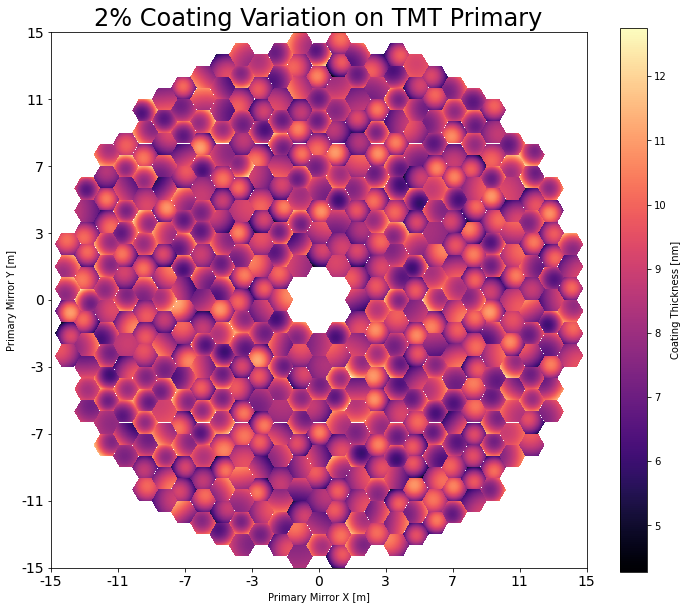

In [79]:
step = int(2048/8)
ticks = np.arange(0,2048+step,step)
tickstr = np.linspace(-15,15,len(ticks))
tickstr = [int(i) for i in tickstr]
plt.figure(figsize=[12,10])
plt.title('2% Coating Variation on TMT Primary',fontsize=24)
plt.imshow(gen_segment_vars(ref_thickness=8.5,nmodes=4,pv_frac=0.5)/pupil_mask,interpolation='none')
plt.colorbar(label='Coating Thickness [nm]')
plt.xticks(ticks,tickstr,fontsize=14)
plt.yticks(ticks,tickstr,fontsize=14)
plt.xlabel('Primary Mirror X [m]')
plt.ylabel('Primary Mirror Y [m]')
plt.show()

## Update the Rayfront surface list

In [72]:
def update_surflist(ncoat=1,nsurf=3,nmodes=4,wavelength=551):

    rf.wavelength = wavelength
    surflist = []

    for i in range(nsurf):

        # apply coating variation
        if i == 0:
            segment_nonuniform = gen_segment_vars(ref_thickness=8.5,pv_frac=0.5).ravel()
            protected_Ag = [
                (np.full_like(segment_nonuniform + 0*1j,f_Si3N4(wavelength)),segment_nonuniform),
                (np.full_like(segment_nonuniform + 0*1j,f_Ag(wavelength)))
            ]
        
        # apply base coating
        else:

            protected_Ag = [
                (np.full_like(segment_nonuniform + 0*1j,f_Si3N4(wavelength)),np.full_like(segment_nonuniform,8.5)),
                (np.full_like(segment_nonuniform + 0*1j,f_Ag(wavelength)))
            ]

        
        sN = {
            'coating':protected_Ag,
            'mode':'reflect'
        }

        surflist.append(sN)
    
    rf.surfaces = surflist
    if nsurf < 3:
        rf.compute_jones_pupil(aloc=np.array([0.,0.,1.]))
    else:
        rf.compute_jones_pupil(aloc=np.array([0.,-1.,0.]))


update_surflist(nsurf=3)


# Do the HCIPy Propagation

In [73]:
from hcipy import *
from poke.interfaces import jones_pupil_to_hcipy_wavefront
x = np.linspace(-1,1,2048)
x,y = np.meshgrid(x,x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask[r<1] = 1

<ipython-input-74-705e76090b9d>:12: RuntimeWarning: invalid value encountered in divide
  imshow_field(wvfnt.Q/pupil_mask.ravel())


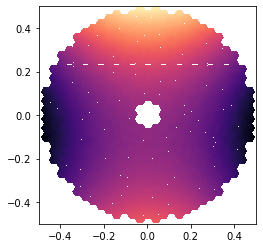

In [74]:
# Propagation grids
pupil_grid = make_pupil_grid(2048)
focal_grid = make_focal_grid(16,12)
prop = FraunhoferPropagator(pupil_grid,focal_grid)

# Make HCIPy wavefront
wvfnt = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,pupil_grid)
aperture = make_circular_aperture(1)

# apply TMT aperture to jones elements
wvfnt.electric_field *= pupil_mask.ravel()
imshow_field(wvfnt.Q/pupil_mask.ravel())

In [75]:
# Set up a PerfectCoronagraph
tmt_aperture = make_tmt_aperture(True,with_spiders=False)
tmt = evaluate_supersampled(tmt_aperture,pupil_grid,1)

In [76]:
coro = PerfectCoronagraph(tmt,order=6)

In [77]:
# compute the PSFs
coro_psf = prop.forward(coro.forward(wvfnt))
coro_ref = prop.forward(wvfnt).intensity.max()

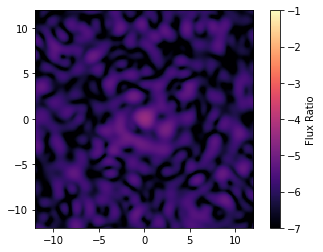

In [78]:
plt.figure()
imshow_field(np.log10(coro_psf.intensity/coro_ref),vmin=-7,vmax=-1)
plt.colorbar(label='Flux Ratio')
plt.show()